In [3]:
from utils.shark_api import ApiReader
import pandas as pd
from utils.calculate import calculate_mining_effort, calculate_time_to_find_block

In [12]:
sharkapi = ApiReader(config_path="../conf")


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

def prepare_data(data):
    df = pd.DataFrame(data)
    df['created'] = pd.to_datetime(df['created'])
    df = df.sort_values('created')
    df['normalized_shares'] = df['difficulty'].astype(float) * (2**32)
    return df

def calculate_pplns_participation(df, window_size=1000):
    # Ensure index is datetime
    df = df.set_index('created')
    
    # Calculate rolling sum of shares for each miner
    miner_shares = df.groupby('miner')['normalized_shares'].rolling(window=window_size).sum().reset_index()
    
    # Pivot the data to have miners as columns
    miner_shares_pivot = miner_shares.pivot(index='created', columns='miner', values='normalized_shares')
    
    # Fill NaN values with 0
    miner_shares_pivot = miner_shares_pivot.fillna(0)
    
    # Calculate total shares in each window
    total_shares = miner_shares_pivot.sum(axis=1)
    
    # Calculate participation ratios
    participation = miner_shares_pivot.div(total_shares, axis=0)
    
    return participation

def plot_participation_over_time(participation):
    plt.figure(figsize=(12, 6))
    for miner in participation.columns:
        plt.plot(participation.index, participation[miner], label=miner)
    plt.title('Miner Participation Over Time')
    plt.xlabel('Time')
    plt.ylabel('Participation Ratio')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    plt.tight_layout()
    plt.show()

    # Add a stacked area chart
    plt.figure(figsize=(12, 6))
    participation.plot.area(stacked=True)
    plt.title('Stacked Miner Participation Over Time')
    plt.xlabel('Time')
    plt.ylabel('Participation Ratio')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
    plt.tight_layout()
    plt.show()

    # Print sum of participations
    participation_sum = participation.sum(axis=1)
    print("Summary of participation sums:")
    print(participation_sum.describe())
    
    if not np.allclose(participation_sum, 1, rtol=1e-5, atol=1e-8):
        print("Warning: Not all participation sums are exactly 1. This might be due to floating-point precision.")



def analyze_pplns(data, window_size=1000, block_reward=10):
    df = prepare_data(data)
    participation = calculate_pplns_participation(df, window_size)

    print("Analyzing PPLNS participation...")
    print(f"Total miners: {participation.columns.nunique()}")
    print(f"Date range: {participation.index.min()} to {participation.index.max()}")
    print(f"Total shares: {df['normalized_shares'].sum():,.0f}")
    
    plot_participation_over_time(participation)
    plot_participation_heatmap(participation)
    # plot_participation_distribution(participation)
    # plot_participation_change_rate(participation)
    # plot_cumulative_rewards(participation, block_reward)

    # Calculate some statistics
    avg_participation = participation.mean()
    max_participation = participation.max()
    min_participation = participation.min()

    print("\nParticipation Statistics:")
    print(pd.DataFrame({
        'Average': avg_participation,
        'Max': max_participation,
        'Min': min_participation
    }))

    # Identify top miners
    top_miners = avg_participation.nlargest(5)
    print("\nTop 5 Miners by Average Participation:")
    print(top_miners)

    # Calculate rewards
    total_blocks = len(participation)
    total_rewards = total_blocks * block_reward
    miner_rewards = (participation * block_reward).sum()

    print(f"\nTotal blocks: {total_blocks}")
    print(f"Total rewards: {total_rewards:,.2f}")
    print("\nMiner Rewards:")
    print(miner_rewards.sort_values(ascending=False))



Analyzing PPLNS participation...
Total miners: 2
Date range: 2024-09-17 14:21:45.106828+00:00 to 2024-09-17 21:40:22.150441+00:00
Total shares: 203,617,380,412


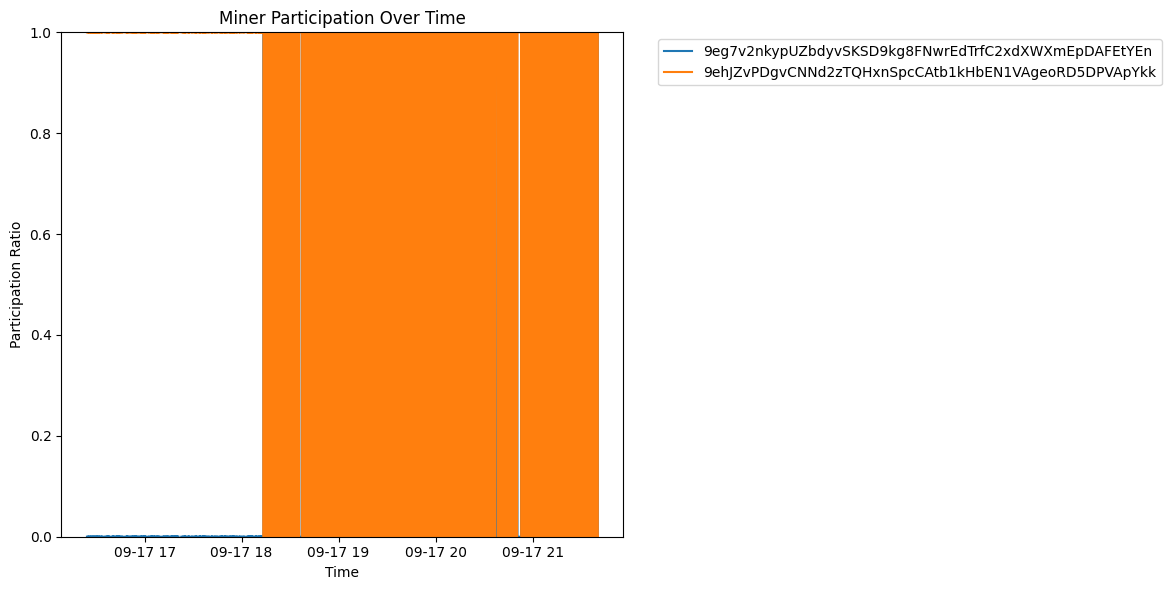

<Figure size 1200x600 with 0 Axes>

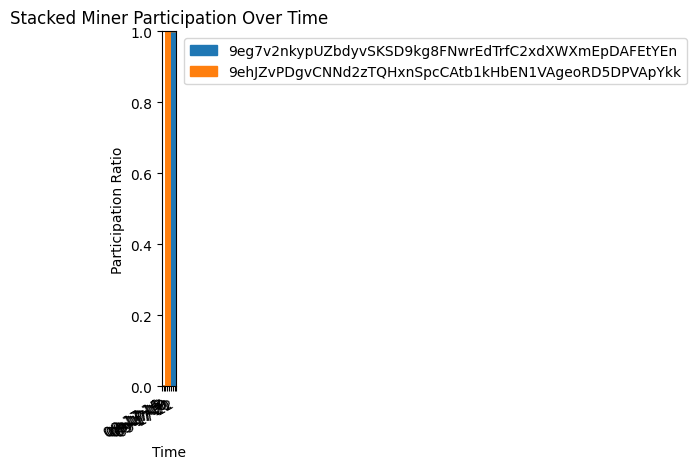

Summary of participation sums:
count    5425.000000
mean        0.631705
std         0.482386
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
dtype: float64


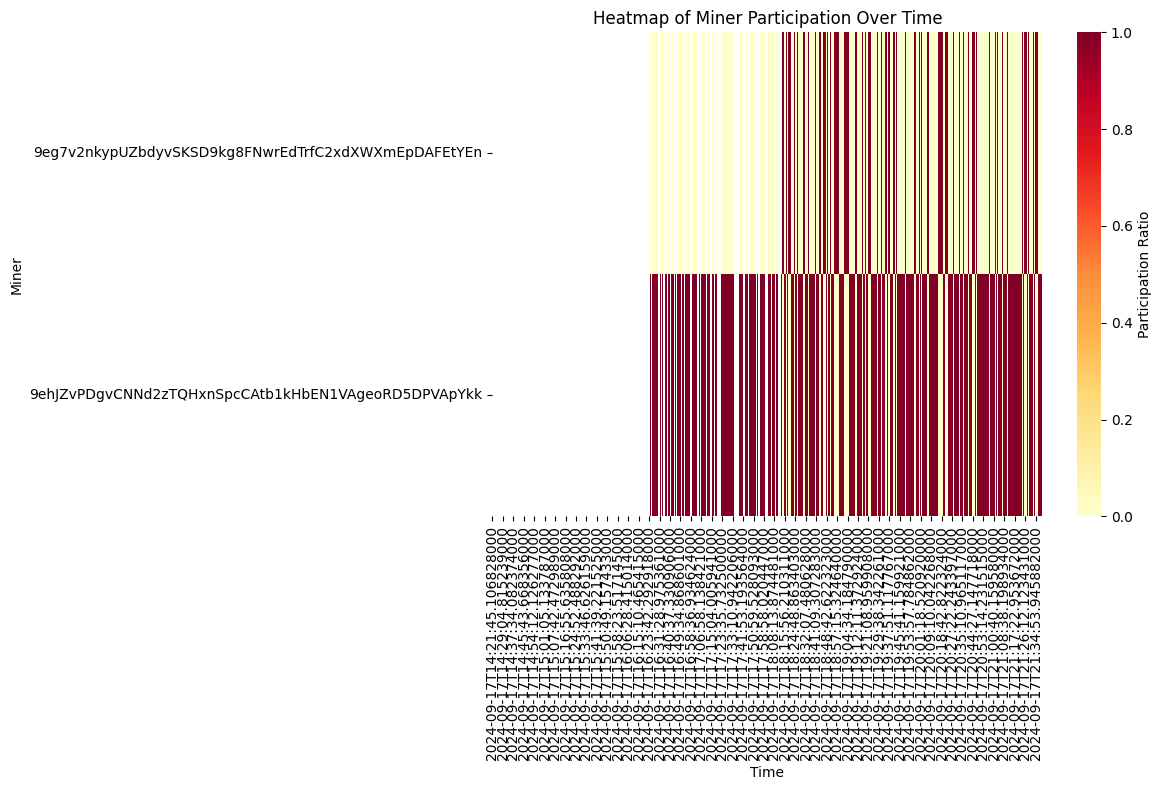

KeyError: "None of [Index([('9eg7v2nkypUZbdyvSKSD9kg8FNwrEdTrfC2xdXWXmEpDAFEtYEn', '9ehJZvPDgvCNNd2zTQHxnSpcCAtb1kHbEN1VAgeoRD5DPVApYkk')], dtype='object', name='miner')] are in the [columns]"

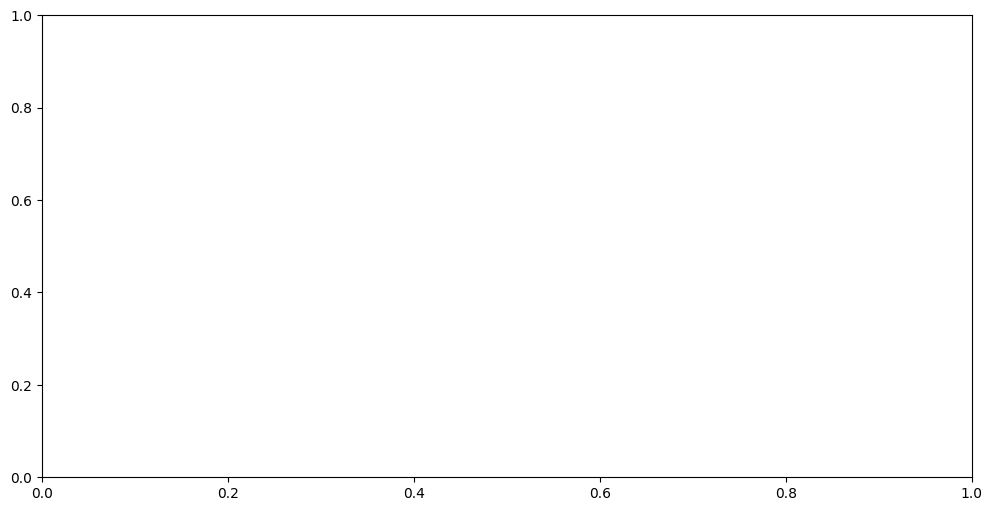

In [39]:
data = sharkapi.get_shares()
analyze_pplns(data, window_size=1000, block_reward=27)

In [40]:
df = prepare_data(data)
pplns_data = calculate_pplns_participation(df, 1000)


In [43]:
pplns_data.last

<bound method NDFrame.last of miner                             9eg7v2nkypUZbdyvSKSD9kg8FNwrEdTrfC2xdXWXmEpDAFEtYEn  \
created                                                                                 
2024-09-17 14:21:45.106828+00:00                                                NaN     
2024-09-17 14:22:20.896486+00:00                                                NaN     
2024-09-17 14:22:35.447983+00:00                                                NaN     
2024-09-17 14:22:44.193679+00:00                                                NaN     
2024-09-17 14:23:04.594473+00:00                                                NaN     
...                                                                             ...     
2024-09-17 21:40:09.254304+00:00                                                1.0     
2024-09-17 21:40:10.275768+00:00                                                1.0     
2024-09-17 21:40:15.867156+00:00                                                